# Wasserstein Singular Vectors for scRNA-seq

This notebook showcases the Wasserstein singular vectors on a scRNA-seq dataset, using entropic regularization and GPU computation.

## Imports

In [ ]:
!pip install pot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ot.gpu
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import cupy as cp
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

## Load data

In [2]:
# Load preprocessed csv
rna = pd.read_csv('sample_data/rna_preprocessed.csv.gz', index_col=0)

In [3]:
# Save labels (one of three cell lines)
labels = np.array([c.split('_')[2] for c in rna.columns])

In [4]:
# Keep only the 1k most varying genes
rna = rna.loc[rna.index[rna.std(1).argsort()[::-1][:1000]]]

## Functions to compute distances

In [7]:
# Compute OT distance matrix
def distance_matrix(A, C, eps, numItermax=5):
  D = cp.zeros((A.shape[1], A.shape[1]))
  for i in range(A.shape[1]):
    D[i, :i+1] = D[:i+1, i] = ot.gpu.sinkhorn(A[:,i], A[:,:i+1], C, eps, to_numpy=False, numItermax=numItermax)
  D -= .5*(cp.diag(D) + cp.diag(D).reshape(-1, 1))
  return D

In [22]:
# Generate random distance-like matrix
def random_distance(n, seed=None):
    np.random.seed(seed)
    D = np.random.rand(n, n)
    D += D.T
    np.fill_diagonal(D, 0)
    return D/D.max()

## Compute Singular Vectors

In [8]:
# Add small weight to avoid division by zero
rna = cp.array(rna) + 1e-6

# Transposed datasets, normalized
A = rna / rna.sum(0)
B = rna.T / rna.sum(1)

In [23]:
# Random cost between genes
C = random_distance(A.shape[0], seed=42)

In [ ]:
# Compute fixed point
n_iter = 10
for _ in range(n_iter):
  print(_, end=' ')
  D = distance_matrix(A, C, .01, numItermax=15)
  D /= D.max()

  C = distance_matrix(B, D, .01, numItermax=15)
  C /= C.max()

## Analyse distance between cells

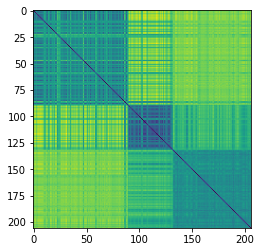

In [5]:
# Euclidean distance matrix
D2 = cdist(cp.asnumpy(rna.T), cp.asnumpy(rna.T))
D2 /= D2.max()
plt.imshow(D2);

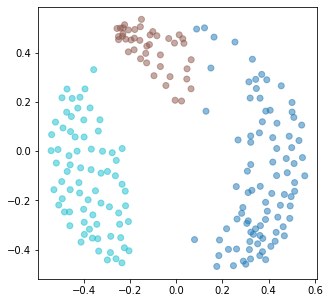

In [6]:
# MDS on euclidean distance matrix
embed = MDS(n_components=2, dissimilarity='precomputed').fit_transform(D2)
plt.figure(figsize=(5, 5))
plt.scatter(embed[:,0], embed[:,1], c=pd.Categorical(labels).codes, cmap='tab10', alpha=.5);

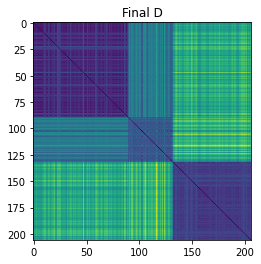

In [13]:
# Display cost between cells
plt.title('Final D')
plt.imshow(cp.asnumpy(D));

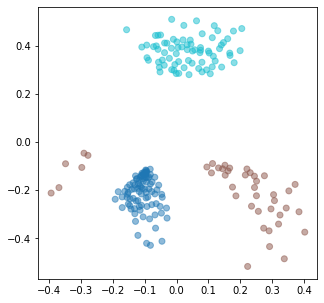

In [24]:
embed = MDS(n_components=2, dissimilarity='precomputed').fit_transform(cp.asnumpy(D))
plt.figure(figsize=(5, 5))
plt.scatter(embed[:,0], embed[:,1], c=pd.Categorical(labels).codes, cmap='tab10', alpha=.5);

## Analyse Distance between genes

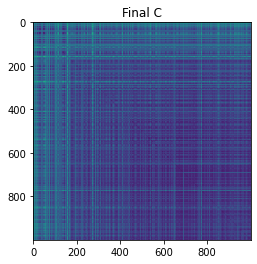

In [12]:
# Display cost between genes
plt.title('Final C')
plt.imshow(cp.asnumpy(C));

In [19]:
# Clustering genes for visalization purposes
cl = AgglomerativeClustering(n_clusters=7, affinity='precomputed', linkage='complete')
cl.fit(cp.asnumpy(C))
idx = np.argsort(cl.labels_)

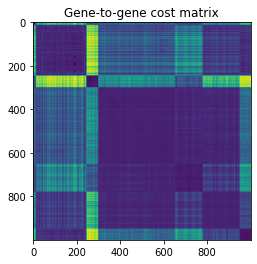

In [20]:
# Clusters are very clear
plt.title('Gene-to-gene cost matrix')
plt.imshow(cp.asnumpy(C)[idx][:,idx]);

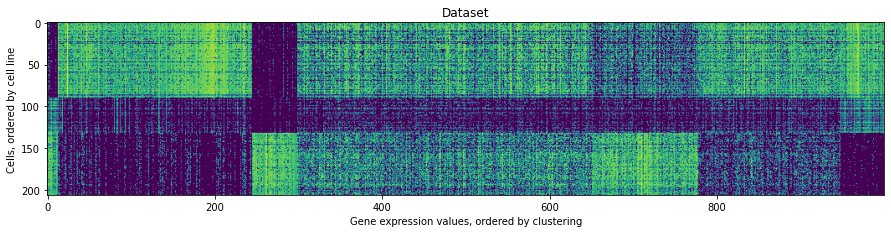

In [21]:
# And these clusters correspond to similar behaviour in the data
plt.figure(figsize=(15, 15))
plt.title('Dataset')
plt.ylabel('Cells, ordered by cell line')
plt.xlabel('Gene expression values, ordered by clustering')
plt.imshow(cp.asnumpy(rna)[idx].T);